# LIBRARY

In [33]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import tokenize
import re
nltk.download('stopwords')
import csv
from openpyxl import Workbook
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt
import networkx as nx



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hkhiy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read Data

In [34]:
df=pd.read_excel(r'C:\Users\hkhiy\Documents\NCKH_Airbnb\Data.xlsx')
df.head()

,reviewer_name,reviewer_country,rental_date,comments
0,Igor,Ba Lan,2023-12-02 00:00:00,The best support I have ever witnessed. Answer...
1,Kevin,Pháp,2023-12-04 00:00:00,Everything is very ok.
2,Walid,Pháp,2023-12-09 00:00:00,"Great accommodation for some games, the owner ..."
3,Maxence,Vương quốc Anh,2023-12-11 00:00:00,Thanks Nigel & Tra for friendly stay in Ho Chi...
4,Lisa,Ai/len,2023-12-10 00:00:00,Nigel and others were very dedicated and respo...


# Clean Data

In [35]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

stopwords_list = set(stopwords.words('english'))
class TextPreprocess():

    def __init__(self):
        pass
        
    def preprocess_text(self,sen):
        if pd.isna(sen):
            return ""
        sen = str(sen).lower()

        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
         # Remove lỗi font
        sentence =  re.sub("[^\x00-\x7F]", " ", sentence)
        
        return sentence





In [36]:
test=TextPreprocess()
X = []
sentences= list(df['comments'])
for sen in sentences:
    X.append(test.preprocess_text(sen))

In [37]:
X[0]


'best support ever witnessed answer fast kind support accommodation close city center minutes walk although place quiet perfect place rest sightseeing party air conditioning projector works well owner provides netflix accounts applications definitely recommend staying '

In [38]:
df['comments'] = X
df.count()

reviewer_name       101566
reviewer_country    101378
rental_date         101567
comments            101567
dtype: int64

# Save After Preprocess Data

In [39]:
df.to_csv(r'C:\Users\hkhiy\Documents\NCKH_Airbnb\after_preprocess.csv', encoding='utf-8')

In [8]:
    # Create a new Excel workbook and save the DataFrame to an Excel file
    #workbook = Workbook()
    #worksheet = workbook.active

    #with open(r'C:\Users\hkhiy\Documents\NCKH_Airbnb\after_preprocess.csv', 'r', encoding='utf-8') as f:
     #   csv_reader = csv.reader(f)
      #  for row in csv_reader:
       #     worksheet.append(row)

    #workbook.save("Data3.xlsx")

# SVM (Support Vector Machine)

# Labeled Data

In [40]:
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return lines

def label_sentiment(comment, positive_words, negative_words):
    if isinstance(comment, str) and comment.strip():  # Kiểm tra nếu comment là một chuỗi không rỗng
        # Chuyển đổi comment thành lowercase để so sánh dễ dàng hơn
        comment_lower = comment.lower()

        # Tách từ trong comment
        words = comment_lower.split()

        # Đếm số lần xuất hiện của các từ tích cực và tiêu cực
        num_positive_words = sum(1 for word in words if word in positive_words)
        num_negative_words = sum(1 for word in words if word in negative_words)

        # Gán nhãn dựa trên số từ tích cực và tiêu cực
        if num_positive_words > num_negative_words:
            return 'positive'
        elif num_positive_words < num_negative_words:
            return 'negative'
        else:
            return 'neutral'  # Nếu số lượng từ tích cực và tiêu cực bằng nhau, gán nhãn là neutral
    else:
        return 'neutral'  # Gán nhãn là neutral cho các comment rỗng hoặc không hợp lệ

# Đọc nội dung từ file positive và negative
positive_words = read_text_file('positive-words.txt')
negative_words = read_text_file('negative-words.txt')

# Xóa ký tự xuống dòng ('\n') ở cuối mỗi từ trong danh sách
positive_words = [word.strip() for word in positive_words]
negative_words = [word.strip() for word in negative_words]

# Đọc dữ liệu từ file CSV
data = pd.read_csv('after_preprocess.csv')

# Gán nhãn sentiment cho mỗi comment trong cột 'comments', loại bỏ các comment trống
data['sentiment'] = data['comments'].apply(lambda x: label_sentiment(x, positive_words, negative_words))

#Gan positive =1, negative=2, neutral=0
X=[]
for label in data['sentiment']:
    if label=="positive":
        X.append(1)
    if label=="negative":
        X.append(2)
    if label=="neutral":
        X.append(0)

data['label']=X

# In ra số lượng mẫu cho mỗi nhãn
print("Số lượng mẫu positive:", len(data[data['sentiment'] == 'positive']))
print("Số lượng mẫu negative:", len(data[data['sentiment'] == 'negative']))
print("Số lượng mẫu neutral:", len(data[data['sentiment'] == 'neutral']))


Số lượng mẫu positive: 78040
Số lượng mẫu negative: 6742
Số lượng mẫu neutral: 16785


In [41]:
data.head()

,Unnamed: 0,reviewer_name,reviewer_country,rental_date,comments,sentiment,label
0,0,Igor,Ba Lan,2023-12-02 00:00:00,best support ever witnessed answer fast kind s...,positive,1
1,1,Kevin,Pháp,2023-12-04 00:00:00,everything ok,positive,1
2,2,Walid,Pháp,2023-12-09 00:00:00,great accommodation games owner responded quickly,positive,1
3,3,Maxence,Vương quốc Anh,2023-12-11 00:00:00,thanks nigel tra friendly stay ho chi minh cit...,positive,1
4,4,Lisa,Ai/len,2023-12-10 00:00:00,nigel others dedicated responded quickly stay ...,positive,1


In [42]:
# Lưu dữ liệu đã gán nhãn vào file CSV mới
data.to_csv('labeled_data_final.csv', index=False)


# Train and Test

In [44]:
df_sentiment=pd.read_csv('labeled_data_final.csv')
df_sentiment.head()
df_sentiment.info

<bound method DataFrame.info of         Unnamed: 0 reviewer_name reviewer_country          rental_date  \
0                0          Igor           Ba Lan  2023-12-02 00:00:00   
1                1         Kevin             Pháp  2023-12-04 00:00:00   
2                2         Walid             Pháp  2023-12-09 00:00:00   
3                3       Maxence   Vương quốc Anh  2023-12-11 00:00:00   
4                4          Lisa           Ai/len  2023-12-10 00:00:00   
...            ...           ...              ...                  ...   
101562      101562        Mayank           Ấn Độ               1/2020   
101563      101563            Ck        Singapore               1/2020   
101564      101564          John              Úc              12/2019   
101565      101565         Shawn           Canada              12/2019   
101566      101566           Ian  Vương Quốc Anh              12/2019   

                                                 comments sentiment  label  
0 

In [45]:
df_sentiment.dropna(subset=['comments'], inplace=True)
df_sentiment.info

<bound method DataFrame.info of         Unnamed: 0 reviewer_name reviewer_country          rental_date  \
0                0          Igor           Ba Lan  2023-12-02 00:00:00   
1                1         Kevin             Pháp  2023-12-04 00:00:00   
2                2         Walid             Pháp  2023-12-09 00:00:00   
3                3       Maxence   Vương quốc Anh  2023-12-11 00:00:00   
4                4          Lisa           Ai/len  2023-12-10 00:00:00   
...            ...           ...              ...                  ...   
101562      101562        Mayank           Ấn Độ               1/2020   
101563      101563            Ck        Singapore               1/2020   
101564      101564          John              Úc              12/2019   
101565      101565         Shawn           Canada              12/2019   
101566      101566           Ian  Vương Quốc Anh              12/2019   

                                                 comments sentiment  label  
0 

In [15]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(df_sentiment['comments'], df_sentiment['label'], test_size = 0.2, random_state = 42)

In [16]:
# Tao dataframe cho train and test
df_train80 = pd.DataFrame()
df_train80['comments'] = train_X
df_train80['label'] = train_Y

df_test20 = pd.DataFrame()
df_test20['comments'] = test_X
df_test20['label'] = test_Y


In [17]:
df_train80

,comments,label
94662,garden lots bugs including mosquitoes ants bee...,2
77838,clean slightly mosquito,1
38415,new hotel beautiful balcony view open staff en...,1
9718,spacious comfortable,1
79778,clean amenities sea view near sea near shoppin...,1
...,...,...
6285,clean,1
55080,hotel owner friendly open,1
77115,shop pretty cafe hall location near sea,1
863,food delicious attractive price reasonable hyg...,1


In [18]:
df_test20

,comments,label
14772,room clean cool great service staff surely com...,1
69447,location attitude,0
86752,room,0
17876,enthusiastic customer support room wide interi...,1
32537,quiet clean accommodation electricity serves q...,1
...,...,...
25727,nice space smooth clean pillow bed beautiful s...,1
35948,quiet area,1
30789,clean many facilities located center go,1
63387,clean,1


In [19]:
df_train80.to_csv('df_train80.csv')
df_test20.to_csv('df_test20.csv')

In [20]:
tfidf_vect_8020 = TfidfVectorizer()
tfidf_vect_8020.fit(df_sentiment['comments'])

# bieu dien vector TF-IDF cua data train & test
train_X_tfidf_8020 = tfidf_vect_8020.transform(df_train80['comments'])
test_X_tfidf_8020 = tfidf_vect_8020.transform(df_test20['comments'])

In [21]:
print(train_X_tfidf_8020)
#print(test_X_tfidf_8020)

  (0, 15194)	0.19443594130138006
  (0, 12474)	0.19443594130138006
  (0, 11352)	0.23942065174951271
  (0, 8762)	0.17387983418235278
  (0, 8523)	0.16299484238014342
  (0, 7786)	0.448851672389599
  (0, 6617)	0.16299484238014342
  (0, 5427)	0.13645730904953823
  (0, 5320)	0.22801596252113712
  (0, 3954)	0.18076845700991104
  (0, 3154)	0.23299786385430213
  (0, 3130)	0.26394826186108755
  (0, 3128)	0.26394826186108755
  (0, 2217)	0.2359790847724848
  (0, 1673)	0.19443594130138006
  (0, 1278)	0.19821073823856086
  (0, 1132)	0.26394826186108755
  (0, 983)	0.20584063052975568
  (0, 495)	0.17798989399934947
  (0, 368)	0.09390167382435595
  (1, 12242)	0.6134286146162453
  (1, 8522)	0.7577616712751418
  (1, 2347)	0.22249176235604295
  (2, 14707)	0.29187794326728667
  (2, 14621)	0.2081300290012546
  :	:
  (80213, 8451)	0.1496965912088929
  (80213, 8387)	0.18751461456723456
  (80213, 8378)	0.1761302551596526
  (80213, 7904)	0.10778138306235648
  (80213, 7812)	0.1036206083194958
  (80213, 7673)	0.17

In [22]:
print(train_X_tfidf_8020.shape)
print(test_X_tfidf_8020.shape)

(80214, 15349)
(20054, 15349)


In [23]:
percent_kept = 0.2  

num_features = int(percent_kept * train_X_tfidf_8020.shape[1])
selector = SelectKBest(chi2, k=num_features)

train_X_tfidf_8020_selected = selector.fit_transform(train_X_tfidf_8020, train_Y)
test_X_tfidf_8020_selected = selector.transform(test_X_tfidf_8020)
     

print(train_X_tfidf_8020_selected.shape)
print(test_X_tfidf_8020_selected.shape)

(80214, 3069)
(20054, 3069)


# Feature Selection

In [24]:
percent_kept = 0.2  
num_features = int(percent_kept * train_X_tfidf_8020.shape[1])

selector = SelectKBest(chi2, k=num_features)

train_X_tfidf_8020_selected = selector.fit_transform(train_X_tfidf_8020, train_Y)
test_X_tfidf_8020_selected = selector.transform(test_X_tfidf_8020)

# Process

In [25]:
model = SVC(C=1, kernel='rbf', gamma="scale")
 
# fit --> train
model.fit(train_X_tfidf_8020_selected, train_Y)

SVC(C=1)

In [26]:
predictions_SVM_8020 = model.predict(test_X_tfidf_8020_selected)

test_prediction_8020 = pd.DataFrame()
test_prediction_8020['comments'] = test_X
test_prediction_8020['label'] = predictions_SVM_8020


SVM_accuracy_8020 = accuracy_score(predictions_SVM_8020, test_Y)*100

SVM_accuracy_8020 = round(SVM_accuracy_8020,1)
     
test_prediction_8020

,comments,label
14772,room clean cool great service staff surely com...,1
69447,location attitude,0
86752,room,0
17876,enthusiastic customer support room wide interi...,1
32537,quiet clean accommodation electricity serves q...,1
...,...,...
25727,nice space smooth clean pillow bed beautiful s...,1
35948,quiet area,1
30789,clean many facilities located center go,1
63387,clean,1


In [27]:
# Luu du lieu test predict
test_prediction_8020.to_csv("test_prediction_8020_final.csv")

In [28]:
SVM_accuracy_8020

96.2

# Accuracy, Precision, Recall, f1-score

In [29]:
from sklearn.metrics import classification_report

print ("\nHere is the classification report:")
print (classification_report(test_Y, predictions_SVM_8020, zero_division='warn'))


Here is the classification report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3117
           1       0.99      0.98      0.99     15570
           2       0.90      0.82      0.86      1367

    accuracy                           0.96     20054
   macro avg       0.92      0.90      0.91     20054
weighted avg       0.96      0.96      0.96     20054



In [49]:
comments1 = "comfortable beautiful apartment"
comments1_vector = tfidf_vect_8020.transform([comments1])  # Vectorizing

# Re-train the model using the full train_X_tfidf_8020 and train_Y
model_full = SVC(C=1, kernel='rbf', gamma="scale")
model_full.fit(train_X_tfidf_8020, train_Y)

# Predict using the model
predicted_class = model_full.predict(comments1_vector)

# Check the predicted class and print the result
if predicted_class == 1:
    print("Positive")
else:
    print("Negative")

Positive


# Save trained model and vector

In [ ]:
joblib.dump(model, "model.pkl")
joblib.dump(tfidf_vect_8020, "vectorizer.pkl")

['vectorizer.pkl']

In [ ]:
chi = [0.1, 0.2, 0.3]
c = [0.1, 1, 10, 100]
kernel = ['rbf', 'poly']
gamma = [0.0001, 0.001, 0.1, 1, 'scale', 'auto']

def mulai(h, i, j, k):
    percent_kept = h
    num_features = int(percent_kept * train_X_tfidf_8020.shape[1])
    selector = SelectKBest(chi2, k=num_features)
    train_X_tfidf_8020_selected = selector.fit_transform(train_X_tfidf_8020, train_Y)
    test_X_tfidf_8020_selected = selector.transform(test_X_tfidf_8020)

    print(f"Chi Square = {h}\tParameter: c={i}, kernel={j}, gamma={k}")
    model = SVC(C=i, kernel=j, gamma=k)
    model.fit(train_X_tfidf_8020_selected, train_Y)

    predictions_SVM_8020 = model.predict(test_X_tfidf_8020_selected)
    test_prediction_8020 = pd.DataFrame()
    test_prediction_8020['comments'] = test_X
    test_prediction_8020['label'] = predictions_SVM_8020
    SVM_accuracy_8020 = accuracy_score(predictions_SVM_8020, test_Y) * 100
    SVM_accuracy_8020 = round(SVM_accuracy_8020, 1)

    print(f"Accuracy: {SVM_accuracy_8020}")
    print("Here is the classification report:")
    print(classification_report(test_Y, predictions_SVM_8020, zero_division=0.0), end="\n")
    print("============================================================")

    data.append({'Chi Square': h, 'C': i, 'Kernel': j, 'Gamma': k, 'Accuracy': SVM_accuracy_8020})

for h in chi:
  data = []
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
  for i in c:
    for j in kernel:
      for k in gamma:
        mulai(h, i, j, k)
  df = pd.DataFrame(data)

  # Sort the DataFrame by Accuracy in descending order
  df_sorted = df.sort_values('Accuracy', ascending=False)

  # Count the number of combinations with the same accuracy
  accuracy_counts = df_sorted['Accuracy'].value_counts().reset_index()
  accuracy_counts.columns = ['Accuracy', 'Count']
  accuracy_counts_sorted = accuracy_counts.sort_values('Accuracy', ascending=False)

  print("All Combinations:")
  print(df)
  print("\nWorst Combination:")
  print(df_sorted.tail(1))
  print("\nModerate Combination:")
  print(df_sorted.iloc[len(df_sorted) // 2])
  print("\nBest Combination:")
  print(df_sorted.head(1))
  print("\nAccuracy Counts:")
  print(accuracy_counts_sorted)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Chi Square = 0.1	Parameter: c=0.1, kernel=rbf, gamma=0.0001
Accuracy: 77.6
Here is the classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3117
           1       0.78      1.00      0.87     15570
           2       0.00      0.00      0.00      1367

    accuracy                           0.78     20054
   macro avg       0.26      0.33      0.29     20054
weighted avg       0.60      0.78      0.68     20054

Chi Square = 0.1	Parameter: c=0.1, kernel=rbf, gamma=0.001
Accuracy: 77.6
Here is the classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3117
           1       0.78      1.00      0.87     15570
           2       0.00      0.00      0.00      1367

    accuracy                           0.78     20054
   macro avg       0.26      0.3

# EDA

In [75]:
df = pd.read_csv("labeled_data_final.csv", header = 0)
df.head(5)

,Unnamed: 0,reviewer_name,reviewer_country,rental_date,comments,sentiment,label
0,0,Igor,Ba Lan,2023-12-02 00:00:00,best support ever witnessed answer fast kind s...,positive,1
1,1,Kevin,Pháp,2023-12-04 00:00:00,everything ok,positive,1
2,2,Walid,Pháp,2023-12-09 00:00:00,great accommodation games owner responded quickly,positive,1
3,3,Maxence,Vương quốc Anh,2023-12-11 00:00:00,thanks nigel tra friendly stay ho chi minh cit...,positive,1
4,4,Lisa,Ai/len,2023-12-10 00:00:00,nigel others dedicated responded quickly stay ...,positive,1


In [76]:
df = df.drop(['reviewer_name','reviewer_country'], axis = 1)
df

,Unnamed: 0,rental_date,comments,sentiment,label
0,0,2023-12-02 00:00:00,best support ever witnessed answer fast kind s...,positive,1
1,1,2023-12-04 00:00:00,everything ok,positive,1
2,2,2023-12-09 00:00:00,great accommodation games owner responded quickly,positive,1
3,3,2023-12-11 00:00:00,thanks nigel tra friendly stay ho chi minh cit...,positive,1
4,4,2023-12-10 00:00:00,nigel others dedicated responded quickly stay ...,positive,1
...,...,...,...,...,...
101562,101562,1/2020,seriously need train staff make drinks embarra...,negative,2
101563,101563,1/2020,need scooter driver get around,neutral,0
101564,101564,12/2019,would expect bit facilities pay million vnd ni...,neutral,0
101565,101565,12/2019,would expect bit facilities pay million vnd ni...,neutral,0


In [77]:
count = df.groupby('sentiment').count()
print(count)

           Unnamed: 0  rental_date  comments  label
sentiment                                          
negative         6742         6742      6742   6742
neutral         16785        16785     15486  16785
positive        78040        78040     78040  78040


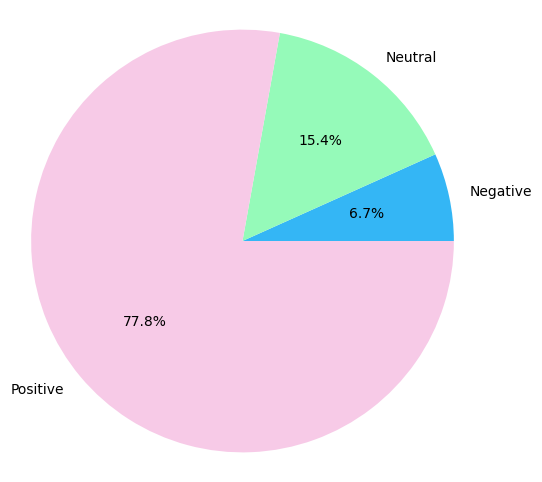

In [78]:
# Tạo DataFrame mẫu
data = {'sentiment': ['Negative', 'Neutral', 'Positive'],
        'comments': [6742, 15486, 78040]}
df1 = pd.DataFrame(data)

# Trích xuất dữ liệu từ DataFrame
sizes = df1['comments']
labels = df1['sentiment']
colors = ['#34b6f5', '#95fab9', '#f7cae7']
# Vẽ biểu đồ hình bánh
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

# Hiển thị biểu đồ
plt.show()


In [79]:
date = df.groupby('rental_date').count()
date.head()
df['rental_date'] = pd.to_datetime(df['rental_date'], format='mixed')

# Extract year from 'rental_date' and count occurrences of each year
year_counts = df['rental_date'].dt.year.value_counts()
print(year_counts)
df_new = pd.DataFrame(year_counts)
df_new = df_new.reset_index()
df_new.columns = ['rental_date', 'count']
df_new

rental_date
2022    32856
2020    31993
2019    23757
2021    12406
2023      555
Name: count, dtype: int64


,rental_date,count
0,2022,32856
1,2020,31993
2,2019,23757
3,2021,12406
4,2023,555


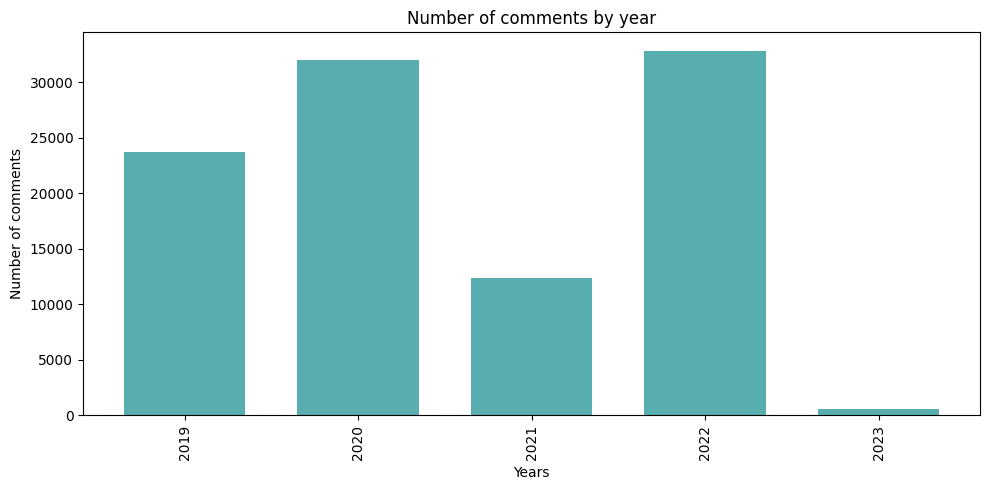

In [80]:
# creating the dataset
courses = list(df_new['rental_date'])
values = list(df_new['count'])

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color='#58AEAE', width=0.7)

plt.xlabel("Years")
plt.ylabel("Number of comments")
plt.title("Number of comments by year")
plt.xticks(courses, rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


# Topic Modeling

# 1. Setting the Working Environment

In [72]:
!pip install pyLDAvis
!pip install wordcloud
!pip install gensim
!pip install nltk

  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached numexpr-2.9.0-cp312-cp312-win_amd64.whl.metadata (8.1 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached smart_open-7.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
Using cached numexpr-2.9.0-cp312-cp312-win_amd64.whl (96 kB)
Using cached smart_open-7.0.1-py3-none-any.whl (60 kB)
Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl (37 kB)
Fai

  error: subprocess-exited-with-error
  
  × Building wheel for gensim (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [714 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\interfaces.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\matutils.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\nosy.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\utils.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\__init__.py -> build\lib.win-amd64-cpython-312\gensim
      creating build\lib.win-amd64-cpython-312\gensim\corpora
      copying gensim\corpora\bleicorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
      copying gensim\corpora\csvcorpus.py -> bui

  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached smart_open-7.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
Using cached smart_open-7.0.1-py3-none-any.whl (60 kB)
Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl (37 kB)
Failed to build gensim


  error: subprocess-exited-with-error
  
  × Building wheel for gensim (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [714 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\interfaces.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\matutils.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\nosy.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\utils.py -> build\lib.win-amd64-cpython-312\gensim
      copying gensim\__init__.py -> build\lib.win-amd64-cpython-312\gensim
      creating build\lib.win-amd64-cpython-312\gensim\corpora
      copying gensim\corpora\bleicorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
      copying gensim\corpora\csvcorpus.py -> bui

In [73]:
!pip install wordcloud

In [74]:
import pyLDAvis
import pyLDAvis.gensim_models 
import pickle
import pandas as pd
import os
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import gensim.corpora as corpora
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pyLDAvis'

# 2. Importing Data

In [ ]:
path = "labeled_data_final.csv"
df = pd.read_csv(os.path.join(path))
print("The shape of data --->",df.shape)
df.head(10) # Print head

NameError: name 'os' is not defined

# 3. Inital Pre-Processing Data

In [ ]:
df['df_text_processed'] = \
df['comments'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['df_text_processed'] = \
df['df_text_processed'].map(lambda x: x.lower())

# Print out the first rows of df
df['df_text_processed'].head()

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\hkhiy\AppData\Local\Temp\ipykernel_7952\3774121499.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['comments'].map(lambda x: re.sub('[,\.!?]', '', x))
C:\Users\hkhiy\AppData\Local\Temp\ipykernel_7952\3774121499.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['comments'].map(lambda x: re.sub('[,\.!?]', '', x))


TypeError: expected string or bytes-like object, got 'float'

# 4. Initating the LDA analysis

In [ ]:
stop_words = stopwords.words('english')
"""
    Functions for converting sentence to words
"""  
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
"""
    Functions removing the stopwords 
"""        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.df_text_processed.values.tolist()#creating the array of token 
data_words = list(sent_to_words(data))#converting them into list

data_words = remove_stopwords(data_words)# remove stop words
print(data_words[:1][0][:30])

In [ ]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Printing the corpus in a numeric form which implies the frequency of the word
print(corpus[:1][0][:30])

In [ ]:
#Showing the code
id2word

# 5. LDA model training

In [ ]:
from pprint import pprint
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# 6. Analysing the LDA model

In [ ]:
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim_models

# Khai báo đường dẫn đến thư mục lưu trữ dữ liệu
LDAvis_data_dir = os.path.join("E:\\NCKH\\NCKHNew\\img", '02_Results')
if not os.path.exists(LDAvis_data_dir):
    os.makedirs(LDAvis_data_dir)

# Đường dẫn tới tệp dữ liệu của pyLDAvis
LDAvis_data_filepath = os.path.join(LDAvis_data_dir, 'ldavis_prepared_'+str(num_topics))

# Kiểm tra xem liệu quá trình chuẩn bị dữ liệu cho trực quan hóa đã được thực hiện chưa
if 1 == 1:
    # Chuẩn bị dữ liệu cho trực quan hóa
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    # Lưu trữ dữ liệu vào một tệp
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load dữ liệu đã chuẩn bị từ tệp
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Lưu trữ trực quan hóa dưới dạng một tệp HTML
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')

# Hiển thị trực quan hóa trên trình duyệt web
pyLDAvis.display(LDAvis_prepared)

# 8. Topic modelling positive comments

In [ ]:
df_pos = df.loc[df['sentiment'] == 'positive']
df_pos

In [ ]:
stop_words = stopwords.words('english')
"""
    Functions for converting sentence to words
"""  
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
"""
    Functions removing the stopwords 
"""        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df_pos.df_text_processed.values.tolist()#creating the array of token 
data_words = list(sent_to_words(data))#converting them into list

data_words = remove_stopwords(data_words)# remove stop words
print(data_words[:1][0][:30])

In [ ]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Printing the corpus in a numeric form which implies the frequency of the word
print(corpus[:1][0][:30])

In [ ]:
#Showing the code
id2word

## LDA training

In [ ]:
from pprint import pprint
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim_models

# Khai báo đường dẫn đến thư mục lưu trữ dữ liệu
LDAvis_data_dir = os.path.join("E:\\NCKH\\NCKHNew\\img", 'pos_Results')
if not os.path.exists(LDAvis_data_dir):
    os.makedirs(LDAvis_data_dir)

# Đường dẫn tới tệp dữ liệu của pyLDAvis
LDAvis_data_filepath = os.path.join(LDAvis_data_dir, 'ldavis_prepared_'+str(num_topics))

# Kiểm tra xem liệu quá trình chuẩn bị dữ liệu cho trực quan hóa đã được thực hiện chưa
if 1 == 1:
    # Chuẩn bị dữ liệu cho trực quan hóa
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    # Lưu trữ dữ liệu vào một tệp
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load dữ liệu đã chuẩn bị từ tệp
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Lưu trữ trực quan hóa dưới dạng một tệp HTML
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')

# Hiển thị trực quan hóa trên trình duyệt web
pyLDAvis.display(LDAvis_prepared)


# 9. Topic modelling negative comments

In [ ]:
df_neg = df.loc[df['sentiment'] == 'negative']
df_neg

In [ ]:
stop_words = stopwords.words('english')
"""
    Functions for converting sentence to words
"""  
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
"""
    Functions removing the stopwords 
"""        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df_neg.df_text_processed.values.tolist()#creating the array of token 
data_words = list(sent_to_words(data))#converting them into list

data_words = remove_stopwords(data_words)# remove stop words
print(data_words[:1][0][:30])

In [ ]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Printing the corpus in a numeric form which implies the frequency of the word
print(corpus[:1][0][:30])

In [ ]:
#Showing the code
id2word

In [ ]:
from pprint import pprint
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim_models

# Khai báo đường dẫn đến thư mục lưu trữ dữ liệu
LDAvis_data_dir = os.path.join("E:\\NCKH\\NCKHNew\\img", 'neg_Results')
if not os.path.exists(LDAvis_data_dir):
    os.makedirs(LDAvis_data_dir)

# Đường dẫn tới tệp dữ liệu của pyLDAvis
LDAvis_data_filepath = os.path.join(LDAvis_data_dir, 'ldavis_prepared_'+str(num_topics))

# Kiểm tra xem liệu quá trình chuẩn bị dữ liệu cho trực quan hóa đã được thực hiện chưa
if 1 == 1:
    # Chuẩn bị dữ liệu cho trực quan hóa
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    # Lưu trữ dữ liệu vào một tệp
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load dữ liệu đã chuẩn bị từ tệp
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Lưu trữ trực quan hóa dưới dạng một tệp HTML
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')

# Hiển thị trực quan hóa trên trình duyệt web
pyLDAvis.display(LDAvis_prepared)